# Predicting Lending Club Loan Defaults

### LendingClub loan origination data from 2007-2015
https://www.kaggle.com/wendykan/lending-club-loan-data

Only the following columns will be used for this project:
> ‘loan_amnt’, ‘funded_amnt’, ‘term’,
‘int_rate’, ‘grade’, ‘annual_inc’, ‘issue_d’, ‘dti’, ‘revol_bal’, ‘total_pymnt’, ‘loan_status’

## Part 1: Data Exploration and Evaluation

Please perform any necessary data engineering (cleaning, aggregation) to understand the
dataset. Please point out any data issues you have found (e.g. nulls and outliers) and any
assumptions you made to handle it. Describe the data and provide relevant visualization and
summary statistics

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')

Import the dataset

In [2]:
loans = pd.read_csv('loan.csv', low_memory=False)
df = loans.iloc[:, [2,3,5,6,8,13,15,24,32,38,16]]

Getting relevant data

In [3]:
df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [4]:
df['term'].value_counts(dropna=False)

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

We only need Fully Paid, Defaulted (includes Charged Off) for 36 Month Loans

In [5]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off','Default'])]
df = df.loc[df['term'].isin([' 36 months'])]

remove term now that we have single value

In [6]:
df = df.iloc[:, [0,1,3,4,5,6,7,8,9,10]]

Create sample for quick reference of data

In [8]:
df.sample(10)

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
977895,25000,25000,6.89,A,125000.0,Dec-2015,14.08,22391,27724.969263,Fully Paid
1078965,10000,10000,14.65,C,65000.0,Sep-2015,23.14,4143,11136.600007,Fully Paid
1625031,2000,2000,5.32,A,95000.0,May-2017,10.89,1748,2078.580000,Fully Paid
1618575,16000,16000,12.62,C,88000.0,May-2017,12.96,8568,3205.860000,Charged Off
1624433,3500,3500,10.49,B,15820.0,May-2017,13.88,5595,3954.858368,Fully Paid
1562183,2700,2700,11.99,B,20000.0,Jul-2017,11.22,2828,2981.185741,Fully Paid
1945751,11925,11925,16.29,D,55000.0,Sep-2014,35.44,17719,5865.020000,Charged Off
707390,10100,10100,15.31,C,134500.0,Mar-2016,6.53,3694,2457.090000,Charged Off
1848762,16450,16450,15.31,C,80000.0,Jun-2012,11.66,12697,19587.108105,Fully Paid
1693424,14000,14000,17.10,C,50000.0,Nov-2013,33.46,180918,16246.390000,Fully Paid


Check for missing values

In [9]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 10 columns and 988774 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
dti,669,188,0.0,857,0.1,float64


Missing values are < 1% so we will drop the rows with missing data

In [10]:
df = df.dropna(subset=['dti'])
df.isnull().sum()

loan_amnt      0
funded_amnt    0
int_rate       0
grade          0
annual_inc     0
issue_d        0
dti            0
revol_bal      0
total_pymnt    0
loan_status    0
dtype: int64

## Part 2: Data Analysis
The goal is to understand if 36 month term loan would be a good investment. Please investigate the following. Assume a 36 month investment period for each loan, and exclude loans with less than 36 months of data available.

### Questions to review

1. What percentage of loans has been fully paid?

In [12]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.839026
Charged Off    0.160954
Default        0.000020
Name: loan_status, dtype: float64

Answer: 83.9%

2. When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not “fully paid” had “defaulted”.

In [14]:
# converting Date
df[["issue_d"]] = pd.to_datetime(df["issue_d"], format = "%b-%Y")
#add year
df['year'] = df['issue_d'].dt.year

In [15]:
#Create y variable loan_is_bad
df['loan_is_bad'] = (df['loan_status'] != 'Fully Paid').apply(np.uint8)
df.groupby('loan_status')['loan_is_bad'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,159117.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Default,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Fully Paid,829449.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
default = df.groupby(['year','grade'], as_index=False)['loan_is_bad'].mean()
default.sort_values(by=['loan_is_bad'], ascending=False)

,year,grade,loan_is_bad
68,2016,G,0.577273
12,2008,G,0.500000
75,2017,G,0.495935
67,2016,F,0.491134
11,2008,F,0.476190
61,2015,G,0.461224
66,2016,E,0.428761
60,2015,F,0.423529
74,2017,F,0.423038
3,2007,D,0.405405


Answer: Loans originating in 2016 with grade 'G' have the highest rate of default at 57.7%

3. When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average? For simplicity, use the following approximation:
> Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1

In [18]:
rtrn = df.groupby(['year','grade'], as_index=False).agg({
        'funded_amnt':sum,
        'total_pymnt':sum
        })

rtrn['rate'] = (rtrn['total_pymnt']/rtrn['funded_amnt'])**(1/3)-1
rtrn.sort_values(by=['rate'], ascending=False)

,year,grade,funded_amnt,total_pymnt,rate
40,2012,G,596075,7.323834e+05,0.071057
39,2012,F,2052775,2.398816e+06,0.053299
31,2011,E,3609325,4.215380e+06,0.053102
38,2012,E,16024050,1.852726e+07,0.049574
30,2011,D,13324425,1.507189e+07,0.041933
37,2012,D,70465400,7.964049e+07,0.041644
5,2007,F,74575,8.427622e+04,0.041607
23,2010,D,11665375,1.312651e+07,0.040120
43,2013,C,302858625,3.406843e+08,0.040010
45,2013,E,32265075,3.624970e+07,0.039578


Answer: Table above, 2012 G has the highest rate of return at 71.1%

### Review Rest of Data

Because we're only using variables available to investors before the loan was funded, issue_d will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

In [20]:
df.drop('total_pymnt', axis=1, inplace=True)
df.drop('funded_amnt', axis=1, inplace=True)

##### loan_amt

In [21]:
df['loan_amnt'].describe()

count    988586.000000
mean      12543.560171
std        8147.255438
min         500.000000
25%        6375.000000
50%       10000.000000
75%       16100.000000
max       40000.000000
Name: loan_amnt, dtype: float64

loans range from 500 to 40,000 with a median of 10,000. 

(array([109771., 261464., 238182., 133021.,  97461.,  46699.,  42011.,
         24101.,  32036.,   3840.]),
 array([  500.,  4450.,  8400., 12350., 16300., 20250., 24200., 28150.,
        32100., 36050., 40000.]),
 <a list of 10 Patch objects>)

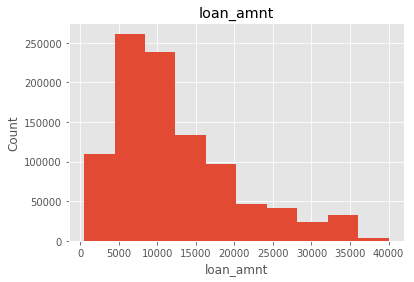

In [22]:
plt.xlabel('loan_amnt')
plt.ylabel('Count')
plt.title('loan_amnt')
plt.hist(df['loan_amnt'])

Text(0.5, 1.0, 'Loan Amnt by Status')

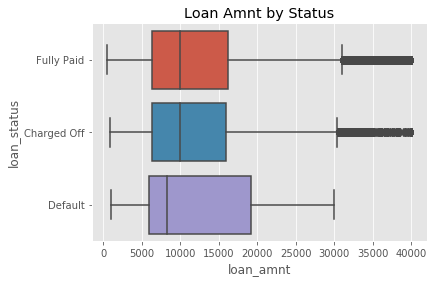

In [23]:
ax = sns.boxplot(x=df['loan_amnt'], y=df['loan_status'], data=df)
ax.set_title('Loan Amnt by Status')

#### int_rate

In [25]:
df['int_rate'].describe()

count    988586.000000
mean         12.132817
std           4.156097
min           5.310000
25%           8.900000
50%          11.990000
75%          14.490000
max          30.990000
Name: int_rate, dtype: float64

Interest rates range from 5.31% to 30.99% (!) with a median of 11.99%.

(array([150393., 205835., 261030., 175993., 111940.,  52015.,  16857.,
         10399.,   2208.,   1916.]),
 array([ 5.31 ,  7.878, 10.446, 13.014, 15.582, 18.15 , 20.718, 23.286,
        25.854, 28.422, 30.99 ]),
 <a list of 10 Patch objects>)

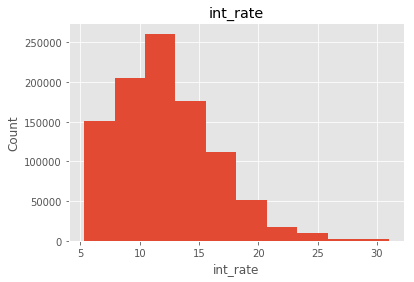

In [26]:
plt.xlabel('int_rate')
plt.ylabel('Count')
plt.title('int_rate')
plt.hist(df['int_rate'])

Text(0.5, 1.0, 'Int Rate by Status')

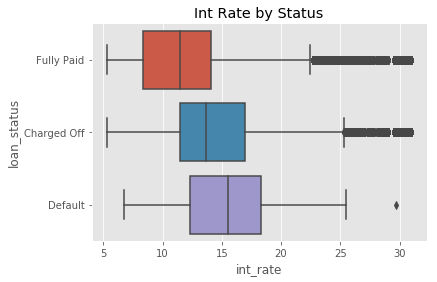

In [27]:
ax = sns.boxplot(x=df['int_rate'], y=df['loan_status'], data=df)
ax.set_title('Int Rate by Status')

Charged off loans have a higher rate than paid ones and Defaults are even higher than charged off.

In [28]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,159117.0,14.164238,4.303316,5.31,11.4400,13.670,16.99,30.99
Default,20.0,15.937500,5.766507,6.71,12.3325,15.505,18.30,29.69
Fully Paid,829449.0,11.743029,4.011233,5.31,8.3800,11.490,14.07,30.99


#### annual_inc

In [31]:
df['annual_inc'].describe()

count    9.885860e+05
mean     7.419665e+04
std      7.092779e+04
min      1.600000e+01
25%      4.400000e+04
50%      6.200000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

Annual income ranges from  $16 𝑡𝑜 $10,999,200, with a median of $62,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [32]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x+1))
df.drop('annual_inc', axis=1, inplace=True)
df['log_annual_inc'].describe()

count    988586.000000
mean          4.798244
std           0.240465
min           1.230449
25%           4.643463
50%           4.792399
75%           4.954247
max           7.041361
Name: log_annual_inc, dtype: float64

(array([3.00000e+00, 0.00000e+00, 8.00000e+00, 6.00000e+01, 4.15700e+03,
        3.68308e+05, 5.91903e+05, 2.36460e+04, 4.41000e+02, 6.00000e+01]),
 array([1.23044892, 1.81154014, 2.39263136, 2.97372259, 3.55481381,
        4.13590503, 4.71699625, 5.29808747, 5.8791787 , 6.46026992,
        7.04136114]),
 <a list of 10 Patch objects>)

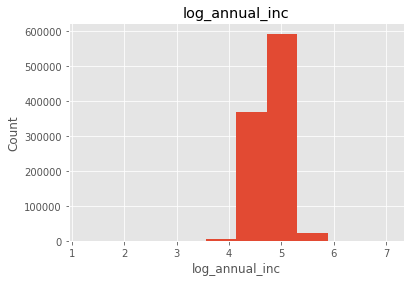

In [33]:
plt.xlabel('log_annual_inc')
plt.ylabel('Count')
plt.title('log_annual_inc')
plt.hist(df['log_annual_inc'])

Text(0.5, 1.0, 'Inc by Status')

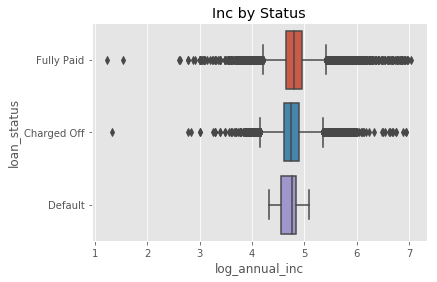

In [34]:
ax = sns.boxplot(x=df['log_annual_inc'], y=df['loan_status'], data=df)
ax.set_title('Inc by Status')

#### dti

In [36]:
df['dti'].describe()

count    988586.000000
mean         17.885886
std          10.446685
min          -1.000000
25%          11.420000
50%          17.220000
75%          23.680000
max         999.000000
Name: dti, dtype: float64

not sure min of -1 and max of 999 make sense

Text(0.5, 1.0, 'Debt-to-income Ratio')

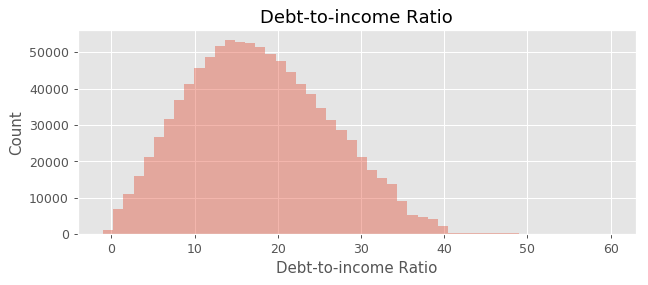

In [38]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the dti values are "outliers" (above 60)?

In [41]:
(df['dti']>=60).sum()

5.35580873944593e-05

In [42]:
(df['dti']>=60).sum()/df['dti'].sum()

5.35580873944593e-05

This doesn't seem like a lot and its less than 1%

In [43]:
df.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,159117.0,19.739850,11.509878,0.0,13.070,19.35,25.960,999.00
Default,20.0,23.903500,9.763354,6.8,19.045,22.92,30.655,42.29
Fully Paid,829449.0,17.530087,10.191604,-1.0,11.160,16.84,23.200,999.00


paid off loans tend to have less dti on average

#### revol_bal

In [44]:
df['revol_bal'].describe()

count    9.885860e+05
mean     1.532221e+04
std      2.212438e+04
min      0.000000e+00
25%      5.505000e+03
50%      1.026100e+04
75%      1.831800e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

large range, doing a log transform

In [45]:
df['log_revol_bal'] = df['revol_bal'].apply(lambda x: np.log10(x+1))
df.drop('revol_bal', axis=1, inplace=True)

(array([5.12300e+03, 8.06000e+02, 2.14000e+03, 7.35700e+03, 3.90460e+04,
        3.07762e+05, 5.43544e+05, 7.90080e+04, 3.75100e+03, 4.90000e+01]),
 array([0.        , 0.64631218, 1.29262435, 1.93893653, 2.58524871,
        3.23156088, 3.87787306, 4.52418524, 5.17049741, 5.81680959,
        6.46312177]),
 <a list of 10 Patch objects>)

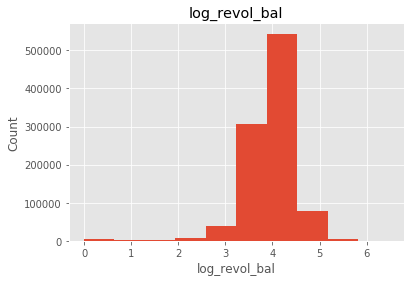

In [47]:
plt.xlabel('log_revol_bal')
plt.ylabel('Count')
plt.title('log_revol_bal')
plt.hist(df['log_revol_bal'])

Text(0.5, 1.0, 'Revoling Ballance by Status')

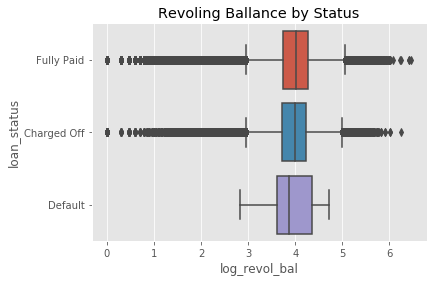

In [48]:
ax = sns.boxplot(x=df['log_revol_bal'], y=df['loan_status'], data=df)
ax.set_title('Revoling Ballance by Status')

In [50]:
df.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,159117.0,3.933313,0.520670,0.00000,3.721233,3.986055,4.228913,6.242223
Default,20.0,3.953456,0.504442,2.83123,3.603225,3.872997,4.355129,4.718618
Fully Paid,829449.0,3.966524,0.536486,0.00000,3.744919,4.016281,4.269630,6.463122


Revol Bal is about the same for all statuses 

#### look at issue_d

In [53]:
df['issue_d'].describe()

count                  988586
unique                    139
top       2015-10-01 00:00:00
freq                    33151
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

Text(0.5, 1.0, 'Loans Funded per Year')

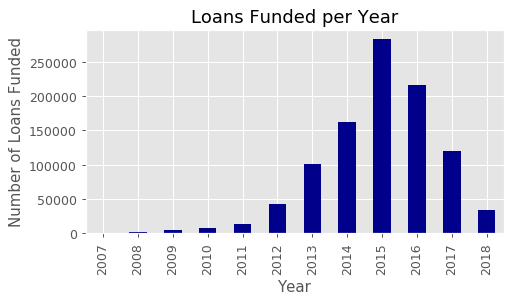

In [54]:
plt.figure(figsize=(6,3), dpi=90)
df['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

#### Drop loan_status as we have loan_is_bad

In [52]:
df.drop('loan_status', axis=1, inplace=True)

### Create Dummy Variables

In [65]:
df = pd.get_dummies(df, columns=['grade'], drop_first=True)

In [71]:
df.sample(5)

,loan_amnt,int_rate,issue_d,dti,year,loan_is_bad,log_annual_inc,log_revol_bal,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
711853,9000,8.39,2016-03-01,11.07,2016,0,4.680345,3.948119,1,0,0,0,0,0
1701403,20000,7.90,2013-11-01,18.88,2013,0,5.079185,4.409629,0,0,0,0,0,0
1027295,35000,12.29,2015-10-01,6.92,2015,0,5.397942,4.605994,0,1,0,0,0,0
594045,10000,13.49,2016-07-01,10.84,2016,1,4.934504,4.719480,0,1,0,0,0,0
1359637,6200,6.99,2017-03-01,33.13,2017,0,4.700297,3.749582,0,0,0,0,0,0


#### Split Train and Test sets
to make the most realistic test and train data sets We'll form the test set from the most recent 10% of the loans.

In [66]:
loans_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.9)]
loans_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [67]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

Number of loans in the partition:    988586
Number of loans in the full dataset: 988586


confirm test size of ~10%

In [68]:
loans_test.shape[0] / df.shape[0]

0.11158766156915029

Look at distribution of dates in test and train

In [69]:
loans_train['issue_d'].describe()

count                  878272
unique                    119
top       2015-10-01 00:00:00
freq                    33151
first     2007-06-01 00:00:00
last      2017-04-01 00:00:00
Name: issue_d, dtype: object

In [70]:
loans_test['issue_d'].describe()

count                  110314
unique                     20
top       2017-05-01 00:00:00
freq                    11729
first     2017-05-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

Delete the issue_d variable, because it was not available before the loan was funded.

In [72]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

In [73]:
loans_train.sample(10)

,loan_amnt,int_rate,dti,year,loan_is_bad,log_annual_inc,log_revol_bal,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
2111428,35000,11.99,22.08,2011,0,4.903095,4.657381,1,0,0,0,0,0
1838957,10000,10.16,17.97,2012,0,4.653222,4.249932,1,0,0,0,0,0
684526,8000,9.16,14.16,2016,0,4.602071,3.834675,1,0,0,0,0,0
544351,34950,17.99,25.30,2016,1,4.844521,4.517156,0,0,1,0,0,0
2038934,16000,8.90,7.02,2014,0,4.826081,4.196370,0,0,0,0,0,0
1651362,10000,13.99,23.14,2017,1,4.573347,4.165363,0,1,0,0,0,0
1788239,6500,8.90,11.83,2013,0,4.763435,3.586812,0,0,0,0,0,0
1722114,18000,9.25,23.06,2013,0,4.812920,4.355337,0,0,0,0,0,0
623515,6500,11.99,26.03,2016,0,4.812920,4.224921,0,1,0,0,0,0
519367,7925,7.99,13.43,2016,0,5.041397,3.899492,0,0,0,0,0,0


#### Separate the predictor variables from the response variable:

In [74]:
y_train = loans_train['loan_is_bad']
y_test = loans_test['loan_is_bad']

X_train = loans_train.drop('loan_is_bad', axis=1)
X_test = loans_test.drop('loan_is_bad', axis=1)

#### Test predictive value of variables  
On the training set, compute the Pearson correlation, 𝐹 -statistic, and 𝑝 value of each predictor with the response variable charged_off.

In [75]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [76]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

𝐹-statistics:

In [77]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [78]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [79]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with charged_off:

In [81]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,int_rate,0.211430,41098.269776,0.000000e+00
1,grade_D,0.109901,10737.547799,0.000000e+00
2,log_annual_inc,-0.087550,6783.887644,0.000000e+00
3,dti,0.087310,6746.546532,0.000000e+00
4,grade_E,0.086911,6684.488514,0.000000e+00
5,grade_C,0.074212,4863.791189,0.000000e+00
6,year,0.073528,4774.000343,0.000000e+00
7,grade_B,-0.064202,3635.090978,0.000000e+00
8,grade_F,0.052239,2403.248720,0.000000e+00
9,grade_G,0.030317,807.959504,1.208879e-177


## Part 3: Model Training and Testing

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

### Logistic regression with SGD training

In [83]:
from sklearn.linear_model import SGDClassifier

The machine learning pipeline:

In [84]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', Imputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


A small grid of hyperparameters to search over:

In [85]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [86]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [87]:
grid_sgdlogreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_in...ndom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__alpha': [1e-05, 0.01, 10], 'model__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [88]:
grid_sgdlogreg.best_score_

0.6626570752343907

Best hyperparameters:

In [89]:
grid_sgdlogreg.best_params_

{'model__alpha': 10, 'model__penalty': 'l2'}

### Random forest classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier

The machine learning pipeline:

In [91]:
pipeline_rfc = Pipeline([
    ('imputer', Imputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Set hyperparameter

In [92]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

Create the search grid object:

In [94]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [95]:
grid_rfc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\s

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_im...ators='warn', n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [96]:
grid_rfc.best_score_

0.48140745358985676

Not quite as good as logistic regression

### k-nearest neighbors

In [97]:
from sklearn.neighbors import KNeighborsClassifier

The machine learning pipeline:

In [98]:
pipeline_knn = Pipeline([
    ('imputer', Imputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Set hyperparameter

In [99]:
param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

Create the search grid object:

In [101]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)


Conduct the grid search and train the final model on the whole dataset:

In [102]:
grid_knn.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
          ...ski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lda__n_components': [3, 9], 'model__n_neighbors': [5, 25, 125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [103]:
grid_knn.best_score_

0.6507021265832985

Almost as good as logistic regression

Best hyperparameters:

In [104]:
grid_knn.best_params_

{'lda__n_components': 3, 'model__n_neighbors': 125}

### Tune hyperparameters on the chosen model  
The three models performed quite similarly according to the AUROC:

In [105]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')
print(grid_knn.best_score_, '- k-nearest neighbors')

Cross-validated AUROC scores
0.6626570752343907 - Logistic regression
0.48140745358985676 - Random forest
0.6507021265832985 - k-nearest neighbors


#### Model Selected: Logistic regression  
was the most accurate and the fastest

Hypertuning:

In [107]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}
print(param_grid_sgdlogreg)

{'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]), 'model__penalty': ['l1', 'l2']}


Create the search grid object:

In [108]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)


Conduct the grid search and train the final model on the whole dataset:

In [109]:
grid_sgdlogreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_in...ndom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__alpha': array([3.16228e-05, 1.00000e-04, 3.16228e-04, 1.00000e-03, 3.16228e-03,
       1.00000e-02, 3.16228e-02, 1.00000e-01, 3.16228e-01, 1.00000e+00,
       3.16228e+00]), 'model__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [110]:
grid_sgdlogreg.best_score_

0.6644863357230987

a little better

Best hyperparameters:

In [111]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.1, 'model__penalty': 'l2'}

### Test set evaluation

In [112]:
from sklearn.metrics import roc_auc_score

In [113]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_score)

0.6771543204214122

The test set AUROC score is higher than the cross-validated score